In [1]:
import numpy as np
import galois
import hashlib
import matplotlib.pyplot as plt

from itertools import permutations

---
# base functions

In [2]:
# Obtain minimal gap between adyacent values for sequence X
def get_min_gap(X):
    gap = np.inf
    q = len(X)

    for i in range(q):

        d = abs(X[(i+1) % q] - X[i])

        if d < gap:
            gap = d

    return gap


# Transform number n to base b
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]


# hamming correlation with shift 0 for sequences
# u and v with the same length (assumed)
def hamming_correlation(u,v):
    u_eq_v = u == v
    return u_eq_v.sum()

# maximal hamming correlation for sequences
# u and v with the same length (assumed)
def maxHC(u,v):

    start = 0
    if np.array_equal(u,v): start = 1

    current_maxHC = 0
    for shift in range(start, len(u)):

        hc = hamming_correlation(u, np.roll(v, shift))
        
        if hc > current_maxHC:
            current_maxHC = hc
    
    return current_maxHC


# average hamming auto correlation for a family of
# sequences with the same length (assumed)
def avg_autoHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for shift in range(1, L):
            _avgHC += hamming_correlation(fam[i], np.roll(fam[i], shift))

    return _avgHC / (M * (L-1))


# average hamming cross correlation for a family of
# sequences with the same length (assumed)
def avg_crossHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for j in range(i):
            for shift in range(L):
                _avgHC += hamming_correlation(fam[i], np.roll(fam[j], shift))

    n = M * (M-1) / 2
    return _avgHC / (L*n)


# average maximal hamming correlation for all paris of
# sequences from a single family
def avg_maxHC(fam):
    mean = 0
    s = len(fam)
    for i in range(s):
        for j in range(i+1):
            mean += maxHC(fam[i], fam[j])

    n = s * (s+1) / 2
    return mean / n


# average maximal hamming correlation for all paris of
# sequences from two families
def avg_maxHC_2fam(fam1, fam2):
    mean = 0
    s = len(fam1)
    for i in range(s):
        for j in range(s):
            mean += maxHC(fam1[i], fam2[j])
        
    n = s**2
    return mean / n

# delete frequences above the maximum, raises error if it
# disrupts the minimum gap property
def filter_freq(seq):
    newseq = np.delete(seq, np.where(seq >= 280)[0])
    assert get_min_gap(newseq) == 8, "couldn't filter sequences while preserving minimum gap"
    return newseq


# greatest common division
def gcd(a, b):
    if(b == 0): return abs(a)
    else: return gcd(b, a % b)


def contains_duplicates(X):
    return len(np.unique(X)) != len(X)

---
# 1st method (family)

Generates a family of sequences with optimal maximal hammig correlation from a single m-sequence

.

Generated sequences have length q = p^n - 1

over an alphabet A of size |A| = p^k

for any given prime number p

and integers k,n s.t. 1 <= k <= n

.


[1] Lempel, A., & Greenberger, H. (1974). Families of sequences with optimal Hamming-correlation properties. IEEE Transactions on Information Theory, 20(1), 90-94.


In [3]:
"""
maps a sequence X in P^k to a value in P_k
where P^k is the set of all words of length k over P
P is the finite field (GF) of order p, i.e. P = {0, 1, ..., p-1}
P_k is the finite field (GF) of order p^k, i.e. P_k = {0, 1, ..., p^k-1}
"""
def sigma_transform(X, p, k):

    Y = []
    q = len(X)
    for j in range(q):

        y_j = 0
        for i in range(k):
            y_j += X[(j+i) % q] * p**i

        Y.append(y_j)

    return Y


"""
Following the construction presented in [1]
given an m-sequence X of length q = p^n - 1 over GF(p)
where p is a prime number
then for each k s.t. 1 <= k <= n, the set F of p^k
sequences is an optimal family

a variation of the sigma transform is used
"""
def optimal_family(X, p, k):

    family = []
    q = len(X)
    for v in range(p**k):

        z = numberToBase(v, p)
        while len(z) < k:
            z.insert(0,0)
        z.reverse()

        Y = []
        for j in range(q):

            y_j = 0
            for i in range(k):
                y_j += ( ( X[ (j+i) % q] + z[i]) % p ) * p**i

            Y.append(y_j)

        family.append(Y)
        #print(f"Y{v} = ", Y)

    return np.array(family)

In [4]:
# test from [1]
# n = 3, then q = len(X) = p^n - 1 = 3^3 - 1 = 26
X = [0,0,1,1,1,0,2,1,1,2,1,0,1,0,0,2,2,2,0,1,2,2,1,2,0,2]
testfam = optimal_family(X, 3, 2)

### test for lora m = 2**5 = 32 frequencies

In [5]:
polys = galois.primitive_polys(2, 5)
poly1 = next(polys)
poly2 = next(polys)

lfsr1 = galois.GLFSR(poly1.reverse())
lfsr2 = galois.GLFSR(poly2.reverse())

In [6]:
poly1

Poly(x^5 + x^2 + 1, GF(2))

In [7]:
poly2

Poly(x^5 + x^3 + 1, GF(2))

In [8]:
0x12

18

In [226]:
p = 2
k = 5
n = 5
q = p**n - 1

x1 = lfsr1.step(q)

method1_fam = optimal_family(np.array(x1), p, k)
method1_fam = method1_fam *8

print(method1_fam.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam),5)}")

(32, 31)
family avg cross HC = 0.96774
family avg auto HC = 0.0
family max HC = 0.93939


In [227]:
x2 = lfsr2.step(q)

method1_fam2 = optimal_family(np.array(x2), p, k)
method1_fam2 = method1_fam2 *8

print(method1_fam2.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam2),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam2),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam2),5)}")

(32, 31)
family avg cross HC = 0.96774
family avg auto HC = 0.0
family max HC = 0.93939


In [228]:
method1_fam3 = np.concatenate((method1_fam, method1_fam2))

print(method1_fam3.shape)
print(f"family avg cross HC = {round(avg_crossHC(method1_fam3),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method1_fam3),5)}")
print(f"family max HC = {round(avg_maxHC(method1_fam3),5)}")

(64, 31)
family avg cross HC = 0.96825
family avg auto HC = 0.0
family max HC = 2.10769


In [229]:
method1_fam3

array([[ 56,  24, 136, ..., 240, 248, 120],
       [ 48,  16, 128, ..., 248, 240, 112],
       [ 40,   8, 152, ..., 224, 232, 104],
       ...,
       [112,  32, 136, ...,  16, 144, 208],
       [104,  56, 144, ...,   8, 136, 200],
       [ 96,  48, 152, ...,   0, 128, 192]])

---
# 2nd method (sequence)

Generates a wide gap sequence with minimum gap e and optimal maximal hamming autocorrelation

.

let X be a WGFHS of length q

over alphabet A of size |A| = l

with minimum gap e

and maximal hamming autocorrelation h

then X is defined by the parameters (q, l, h, e)
.




In [4]:
"""
let l, d s.t. 1 < d < l/2
& gcd(l, d) = gcd(l, d+1) = 1

generate an optimal WGFHS with parameters (2*l, l, 2, d-1)
"""
def get_2l_sequence(l, d):
    s = []
    t = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )

    return np.array(s + t)


"""
let l, d s.t. 1 < d < (l-1)/2
& gcd(l, d) = gcd(l, d+1) = gcd(l, d+2) = 1

generate an optimal WGFHS with parameters (3*l, l, 3, d-1)
"""
def get_3l_sequence(l, d):
    s = []
    t = []
    u = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )
        u.append( (i*(d+2) + 2) % l )

    return np.array(s + t + u)


def split_seq(q, seq):
    family = []
    i=0
    j=q
    while j < len(seq):
        family.append(seq[i:j])
        i+=q
        j+=q

    return np.array(family)


#### 2*l seq

In [5]:
l = 277
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}")

x = get_2l_sequence(l, d)
method2_fam1_2l = split_seq(34, x)

print(method2_fam1_2l.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam1_2l),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam1_2l),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam1_2l),5)}")

a=1	b=1
(16, 34)
family avg cross HC = 0.0652
family avg auto HC = 0.00379
family max HC = 0.72059


In [5]:
l = 281
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}")

x = get_2l_sequence(l, d)
method2_fam2_2l = split_seq(31, x)

print(method2_fam2_2l.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam2_2l),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam2_2l),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam2_2l),5)}")

a=1	b=1
(18, 31)
family avg cross HC = 0.0584
family avg auto HC = 0.0
family max HC = 0.47953


In [15]:
method2_fam3_2l = split_seq(31, filter_freq(get_2l_sequence(283, d)))
method2_fam4_2l = split_seq(31, filter_freq(get_2l_sequence(287, d)))

method2_fam5_2l = np.concatenate((method2_fam1_2l, method2_fam2_2l, method2_fam3_2l, method2_fam4_2l))

print(method2_fam5_2l.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam5_2l),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam5_2l),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam5_2l),5)}")

(71, 31)
family avg cross HC = 0.09829
family avg auto HC = 0.0
family max HC = 1.76917


#### 3*l seq

In [83]:
l = 277
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
method2_fam1 = split_seq(31, x)

print(method2_fam1.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam1),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam1),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam1),5)}")

a=1	b=1	c=1
(26, 31)
family avg cross HC = 0.07752
family avg auto HC = 0.0
family max HC = 0.7037


In [84]:
l = 281
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam2 = split_seq(31, xx)

print(method2_fam2.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam2),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam2),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam2),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.69048


In [85]:
l = 283
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam3 = split_seq(31, xx)

print(method2_fam3.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam3),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam3),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam3),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.74603


In [86]:
l = 287
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

x = get_3l_sequence(l, d)
xx = filter_freq(x)
method2_fam4 = split_seq(31, xx)

print(method2_fam4.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam4),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam4),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam4),5)}")

a=1	b=1	c=1
(27, 31)
family avg cross HC = 0.07665
family avg auto HC = 0.0
family max HC = 0.71164


In [87]:
method2_fam5 = np.concatenate((method2_fam1, method2_fam2, method2_fam3, method2_fam4))

print(method2_fam5.shape)
print(f"family avg cross HC = {round(avg_crossHC(method2_fam5),5)}")
print(f"family avg auto HC = {round(avg_autoHC(method2_fam5),5)}")
print(f"family max HC = {round(avg_maxHC(method2_fam5),5)}")

(107, 31)
family avg cross HC = 0.10251
family avg auto HC = 0.0
family max HC = 1.56646


#### eu 336

In [6]:
l = 689
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}")

x = get_2l_sequence(l, d)
method2_fam1_2l = split_seq(86, x)

print(method2_fam1_2l.shape)

a=1	b=1
(16, 86)


#### us

In [12]:
l = 3121
d = 52

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}")

x = get_2l_sequence(l, d)
method2_fam1_2l = split_seq(60, x)

print(method2_fam1_2l.shape)

a=1	b=1
(104, 60)


---
# LR-FHSS FHS with 32 bit sha256 hash function  

In [12]:
# obw to transmit fragment k for node x 
def get_obw(x, k):

    i = x + k * 2**16
    i = int.to_bytes(i, 4, 'little')

    h = int.from_bytes(hashlib.sha256(i).digest()[:4], 'little')

    return ( h % 35 ) * 8 + np.random.randint(8)


# q length sequence of owb's for node x
def get_hashFHS(x, q):
    fhs = []
    for k in range(q):
        fhs.append(get_obw(x, k))
        
    return fhs


# all possible fhs of length q
def get_hashFamily(q):
    fam = []
    for x in range(384):
        fam.append(get_hashFHS(x, q))

    return np.array(fam)

In [13]:
q = 31
hash_fam = get_hashFamily(q)

print(hash_fam.shape)
print(f"family avg cross HC = {round(avg_crossHC(hash_fam),5)}")
print(f"family avg auto HC = {round(avg_autoHC(hash_fam),5)}")
print(f"family max HC = {round(avg_maxHC(hash_fam),5)}")

(384, 31)
family avg cross HC = 0.1108
family avg auto HC = 0.11007
family max HC = 1.12877


---
# real lrfhss sequences

In [14]:
def lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid):
    
    hop = 0
    while 1:

        lsb = lfsr_state & 1
        lfsr_state >>= 1
        if lsb:
            lfsr_state ^= polynomial

        hop = xoring_seed
        if hop != lfsr_state:
            hop ^= lfsr_state

        if hop <= n_grid:
            break

    return lfsr_state, hop - 1


# get lr fhss sequence of length 31
def get_lr_fhss_seq(id):
    n_grid = 35
    lr_fhss_lfsr_poly1 = [33, 45, 48, 51, 54, 57]

    lfsr_state = 6
    fhs = []

    polynomial = lr_fhss_lfsr_poly1[id >> 6]
    xoring_seed = id & 0x3F

    for _ in range(31):
        lfsr_state, hop = lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid)
        fhs.append(hop)

    #print(f"id={id}\tpoly={polynomial}\tseed={xoring_seed}\nseq = {fhs}\n")

    return fhs

def get_lr_fhss_family():
    fam = []
    for id in range(384):
        fam.append(get_lr_fhss_seq(id))

    return np.array(fam)

In [15]:
lr_fhss_family = get_lr_fhss_family()
print(lr_fhss_family.shape)
print(f"family avg cross HC = {round(avg_crossHC(lr_fhss_family),5)}")
print(f"family avg auto HC = {round(avg_autoHC(lr_fhss_family),5)}")
print(f"family max HC = {round(avg_maxHC(lr_fhss_family),5)}")

(384, 31)
family avg cross HC = 0.88548
family avg auto HC = 0.0
family max HC = 3.34418


In [4]:
def calculate_period(L):
    t=0
    for l in L[1:]:
        t+=1
        if l==L[0]: break
    return t

# lr_fhss_lfsr_poly1[] = { 33, 45, 48, 51, 54, 57 };
# lr_fhss_lfsr_poly2[] = { 65, 68, 71, 72 };

seq = []
lfsr_state = 6
poly = 65
seed = 0
ngrid = 99
for _ in range(200):
    lfsr_state, hop = lr_fhss_get_next_state(lfsr_state, poly, seed, ngrid)
    seq.append(hop)


calculate_period(seq)

99

In [45]:
print(seq)

[2, 63, 31, 15, 7, 3, 1, 0, 64, 96, 62, 93, 46, 85, 42, 83, 41, 20, 74, 49, 24, 76, 56, 92, 58, 91, 45, 22, 73, 36, 82, 51, 25, 12, 70, 97, 48, 88, 60, 94, 54, 89, 44, 86, 52, 90, 53, 26, 75, 37, 18, 71, 35, 17, 8, 68, 98, 55, 27, 13, 6, 65, 32, 80, 61, 30, 77, 38, 81, 40, 84, 57, 28, 78, 50, 87, 43, 21, 10, 67, 33, 16, 72, 59, 29, 14, 69, 34, 79, 39, 19, 9, 4, 66, 95, 47, 23, 11, 5, 2, 63, 31, 15, 7, 3, 1, 0, 64, 96, 62, 93, 46, 85, 42, 83, 41, 20, 74, 49, 24, 76, 56, 92, 58, 91, 45, 22, 73, 36, 82, 51, 25, 12, 70, 97, 48, 88, 60, 94, 54, 89, 44, 86, 52, 90, 53, 26, 75, 37, 18, 71, 35, 17, 8, 68, 98, 55, 27, 13, 6, 65, 32, 80, 61, 30, 77, 38, 81, 40, 84, 57, 28, 78, 50, 87, 43, 21, 10, 67, 33, 16, 72, 59, 29, 14, 69, 34, 79, 39, 19, 9, 4, 66, 95, 47, 23, 11, 5, 2, 63]


---
# One Coincidence WG FHS

Bin, L. (1997). One-coincidence sequences with specified distance between adjacent symbols for frequency-hopping multiple access. IEEE Transactions on Communications, 45(4), 408-410.

Refer to the Theroem 2 for the construction

In [14]:
def cond1(L, k, q):
    c1 = True
    for i in range(k):
        if L[i] + L[i+k] != q:
            c1 = False

    return c1


def get_D_val(L, n, j, q):
    l = len(L)
    return sum( [ L[i % l] for i in range(n, n+j) ] ) % q


def cond2(L, k, q):
    c2 = True
    for j in range(2, k+1):
        Darray = [get_D_val(L, n, j, q) for n in range(2*k)]
        if contains_duplicates(Darray):
            c2 = False

    return c2  


def get_generator_seq(q, d):

    k = (q - 2*d - 1) // 2
    L = [i for i in range(d+1, q-d)]

    for C in permutations(L, 2*k):
        if cond1(C, k, q) and cond2(C, k, q):
            return C
        
    return []

In [63]:
q = 13
d = 0

x = get_generator_seq(q,d)
x

(1, 2, 4, 8, 3, 6, 12, 11, 9, 5, 10, 7)

In [66]:
q = 279
d = 7

x = get_generator_seq(q,d)
x

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3771023591.py", line 4, in <module>
    x = get_generator_seq(q,d)
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3072520451.py", line 35, in get_generator_seq
    if cond1(C, k, q) and cond2(C, k, q):
  File "C:\Users\diego\AppData\Local\Temp\ipykernel_19004\3072520451.py", line -1, in cond1
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 1997, in showtraceback
    stb = 

---
# OC WG FHS algebraic construction, primitive element

Wang, T., Niu, X., Wang, J., & Shao, M. (2022, August). A New Class of Optimal Wide-Gap One-Coincidence Frequency-Hopping Sequence. In 2022 10th International Workshop on Signal Design and Its Applications in Communications (IWSDA) (pp. 1-5). IEEE.

- Construction 1 and Theorem 1:

Let $p > 4$ be a prime number and $w$ a positive integer s.t. $2 \leq w \leq p-2$. Let $\alpha$ be a primitive element of $GF(p)$ and $\langle \cdot \rangle$ denote the $mod$ $p$ operator 

Then the set $B = \{b_k = b_k(i) , 0 \leq i \leq p-2, 0 \leq k \leq p-1\}$ is an optimal OC-FHS set with $p$ sequences of length $p-1$ over a frequency set $F$ s.t. $|F|= \ell = wp - w^2 + p - 1$

where

$b_k(i) = k + \sum_{j=k}^{k+w-1} \langle \alpha^i + j \rangle $

- Theorem 2:

For any given minimum wide-gap $D$ with $2 ≤ D ≤ ⌊ \frac{p}{4} ⌋$, the set obtained by filtering the sequences of the set $B$ according to the gap $D$ is an optimal OC-WG-FHS set 

In [70]:
def get_FHSsequence(p, q, w, a, k):
    fhs = []
    for i in range(q):  # max length is p-1
        fhs.append( sum( [(a**i + j) % p for j in range(k, k+w)] ) +k)

    return fhs


def get_WGFHSset(p, q, w, a, d):
    FHSset = np.array([get_FHSsequence(p, q, w, a, k) for k in range(p)])
    WGFHSset = []
    for b in FHSset:
        if get_min_gap(b) >= d:
            WGFHSset.append(b)

    return np.array(WGFHSset)

primitive elements of GF(37) =  [ 2  5 13 15 17 18 19 20 22 24 32 35]


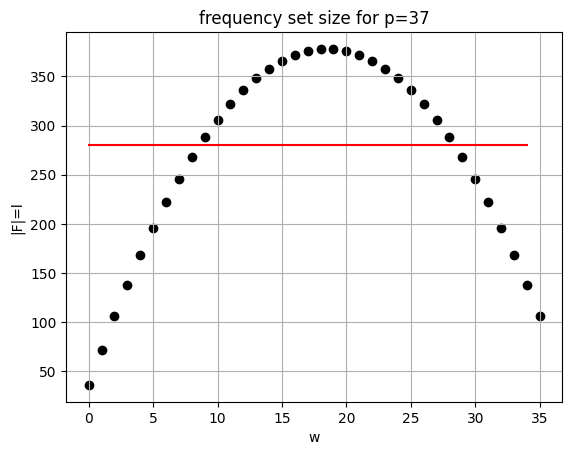

In [71]:
p=37

p_elements = galois.GF(p).primitive_elements
print(f"primitive elements of GF({p}) = ", p_elements)

for w in range(p-1):
    plt.scatter(w, w*p - w**2 + p - 1, color='k')

plt.plot([x for x in range(w)], [280 for x in range(w)], color='r')
plt.title(f'frequency set size for p={p}')
plt.xlabel('w')
plt.ylabel('|F|=l')
plt.grid()
plt.show()

In [72]:
a = int(p_elements[0])
q = 31
w = 8
d = 8
WGFHSset = get_WGFHSset(p, q, w, a, d)

print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(18, 31)
family avg cross HC = 0.10458
family avg auto HC = 0.0
family max HC = 0.91813


In [73]:
for a in p_elements[1:]:
    WGFHSset = np.concatenate([WGFHSset, get_WGFHSset(p, q, w, int(a), d)])

print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(211, 31)
family avg cross HC = 0.12587
family avg auto HC = 0.0
family max HC = 1.21126


---
# OC WG FHS algebraic construction, no primitive element

Ren, W., & Wang, F. (2023). A new class of optimal wide-gap one-coincidence frequency-hopping sequence sets. Advances in Mathematics of Communications, 17(2), 342-352.

- Theorem 3.1:

Let $p > 2$ be a prime number and $w$ a positive integer s.t. $1 \leq w \leq p-1$ and $\langle \cdot \rangle$ denote the $mod$ $p$ operator 

Then the set $B = \{b_k = b_k(i) , 0 \leq i \leq p-1, 1 \leq k \leq p-1\}$ is an optimal OC-FHS set with $p-1$ sequences of length $p$ over a frequency set $F$ s.t. $|F|= \ell = wp - w^2 + 1$

where

$b_k(i) = \sum_{j=i}^{i+w-1} \langle jk \rangle $

- Theorem 4.3:

For any given minimum wide-gap $D$ with $0 < D \leq \frac{p-1}{2}$, the set obtained by filtering the sequences of the set $B$ according to the gap $D$ is an optimal OC-WG-FHS set 

In [30]:
def get_FHSsequence2(p, w, k):
    fhs = []
    for i in range(p):
        fhs.append( sum( [(j*k) % p for j in range(i, i+w)] ) )

    return fhs


def get_WGFHSset2(p, w, d):
    FHSset = np.array([get_FHSsequence2(p, w, k) for k in range(1,p)])
    WGFHSset = []
    for b in FHSset:
        if get_min_gap(b) >= d:
            WGFHSset.append(b)

    return np.array(WGFHSset)

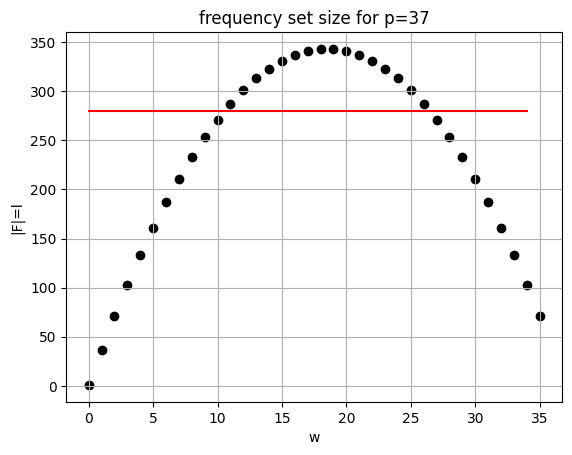

In [31]:
p = 37
for w in range(p-1):
    plt.scatter(w, w*p - w**2 + 1, color='k')

plt.plot([x for x in range(w)], [280 for x in range(w)], color='r')
plt.title(f'frequency set size for p={p}')
plt.xlabel('w')
plt.ylabel('|F|=l')
plt.grid()
plt.show()


In [32]:
w = 10
d = 8
WGFHSset = get_WGFHSset2(p, w, d)

In [33]:

print(WGFHSset.shape)
print(f"family avg cross HC = {round(avg_crossHC(WGFHSset),5)}")
print(f"family avg auto HC = {round(avg_autoHC(WGFHSset),5)}")
print(f"family max HC = {round(avg_maxHC(WGFHSset),5)}")

(22, 37)
family avg cross HC = 0.43185
family avg auto HC = 0.0
family max HC = 0.91304


---

In [6]:
def numHops(payload_length, CR):

    assert CR==1 or CR==2, "Only CR 1/3 and CR 2/3 supported"

    length_bits = ( payload_length + 2 ) * 8 + 6
    length_bits = length_bits * 3 // CR

    nb_hops_out = ( length_bits + 47 ) // 48

    return nb_hops_out

In [14]:
numHops(29, 2)

8

In [15]:
numHops(13, 1)

8

In [4]:
16*8*4

512

In [3]:
import numpy as np
asd = [int(i) for i in np.logspace(1.0, 4.0, num=50)]
print(asd[-7:])

[4291, 4941, 5689, 6551, 7543, 8685, 10000]


In [3]:
x=[int(i) for i in np.logspace(1.0, 3.5, num=40)]
print(x)

[10, 11, 13, 15, 18, 20, 24, 28, 32, 37, 43, 50, 58, 68, 78, 91, 106, 122, 142, 165, 191, 221, 257, 298, 345, 400, 464, 537, 623, 722, 837, 970, 1125, 1304, 1511, 1752, 2030, 2353, 2728, 3162]


In [5]:
def lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid):
    
    hop = 0

    lsb = lfsr_state & 1
    lfsr_state >>= 1
    if lsb:
        lfsr_state ^= polynomial

    hop = xoring_seed
    if hop != lfsr_state:
        hop ^= lfsr_state

    return lfsr_state, hop - 1


def lr_fhss_get_next_state2(lfsr_state, polynomial, xoring_seed, n_grid):
    
    hop = 0
    while 1:

        lsb = lfsr_state & 1
        lfsr_state >>= 1
        if lsb:
            lfsr_state ^= polynomial

        hop = xoring_seed
        if hop != lfsr_state:
            hop ^= lfsr_state

        if hop <= n_grid:
            break

    return lfsr_state, hop - 1



# get lr fhss sequence of length 31
def get_lr_fhss_seq(id):
    n_grid = 35
    lr_fhss_lfsr_poly1 = [33, 45, 48, 51, 54, 57]

    lfsr_state = 6
    fhs = []

    polynomial = lr_fhss_lfsr_poly1[id >> 6]
    xoring_seed = id & 0x3F

    for _ in range(35):
        lfsr_state, hop = lr_fhss_get_next_state2(lfsr_state, polynomial, xoring_seed, n_grid)
        fhs.append(hop)

    #print(f"id={id}\tpoly={polynomial}\tseed={xoring_seed}\nseq = {fhs}\n")

    return fhs

In [37]:
fhs0 = get_lr_fhss_seq(0)
print(fhs0)
fhs1 = get_lr_fhss_seq(111)
print(fhs1)

print(f"maxHC: {maxHC(fhs0,fhs1)}")

[2, 31, 15, 7, 3, 1, 0, 32, 48, 56, 60, 62, 61, 30, 45, 22, 41, 20, 42, 51, 25, 12, 38, 49, 24, 44, 54, 57, 28, 46, 53, 26, 43, 21, 10, 35, 17, 8, 36, 50, 55, 27, 13, 6, 33, 16, 40, 52, 58, 59, 29, 14, 37, 18, 39, 19, 9, 4, 34, 47, 23, 11, 5]
[43, 2, 56, 35, 6, 58, 36, 41, 46, 20, 49, 11, 18, 48, 31, 4, 57, 7, 16, 47, 12, 61, 9, 15, 28, 53, 13, 17, 27, 26, 52, 33, 3, 22, 50, 32, 39, 0, 55, 8, 59, 10, 60, 37, 5, 21, 29, 25, 23, 24, 51, 14, 62, 38, 42, 44, 45, 1, 19, 30, 54, 34, 40]
maxHC: 6


In [8]:
fhs0 = get_lr_fhss_seq(0)
print(fhs0)
fhs1 = get_lr_fhss_seq(1)
print(fhs1)


[2, 31, 15, 7, 3, 1, 0, 32, 30, 22, 20, 25, 12, 24, 28, 26, 21, 10, 17, 8, 27, 13, 6, 33, 16, 29, 14, 18, 19, 9, 4, 34, 23, 11, 5]
[1, 32, 16, 8, 4, 2, 0, 31, 29, 21, 19, 26, 11, 23, 27, 25, 22, 9, 18, 7, 28, 14, 5, 34, 15, 30, 13, 17, 20, 10, 3, 33, 24, 12, 6]


In [14]:
print(get_lr_fhss_seq(383))

[6, 34, 4, 33, 7, 28, 13, 29, 21, 17, 15, 16, 12, 9, 27, 22, 3, 26, 1, 23, 20, 11, 30, 5, 25, 19, 18, 2, 32, 0, 31, 8, 10, 24, 14]


In [1]:
import numpy as np

In [4]:
m = np.asarray([[1,2,3],
                [4,5,6],
                [7,8,9]])

print(m)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [5]:
m[1][1:3] = 0

print(m)

[[1 2 3]
 [4 0 0]
 [7 8 9]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nodes = np.array([10,12,16,20,26,33,42,54,69,88,112,143,183,233,297,379,483,615,784,1000])
tp = np.array([0.0,0.0,0.0,0.2,0.1,0.8,1.6,2.6,7.5,10.9,24.4,42.8,70.6,117.8,183.3,265.5,370.3,507.8,681.5,893.6])

data = np.array([np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0.1, 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.2, 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.1, 0. , 0. , 0. , 0. , 1.5, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.6, 0.1, 0. , 0. , 0. , 1.9, 0. , 0. , 0. , 0. , 0. ]),
 np.array([1. , 0.2, 0. , 0.1, 0.2, 6. , 0. , 0. , 0. , 0. , 0. ]),
 np.array([1.2, 0. , 0.3, 0.2, 0.2, 9. , 0. , 0. , 0. , 0. , 0. ]),
 np.array([ 2.4,  0.1,  0.4,  0.4,  0.4, 20.7,  0. ,  0. ,  0. ,  0. ,  0. ]),
 np.array([ 5.2,  0.5,  0.5,  1. ,  0.8, 34.6,  0.2,  0. ,  0. ,  0. ,  0. ]),
 np.array([10.2,  1. ,  1.3,  0.7,  1.5, 55.8,  0.1,  0. ,  0. ,  0. ,  0. ]),
 np.array([16.5,  1. ,  1.7,  1.4,  2.9, 93.7,  0.6,  0. ,  0. ,  0. ,  0. ]),
 np.array([2.650e+01, 2.700e+00, 3.400e+00, 2.500e+00, 4.100e+00, 1.414e+02, 2.600e+00, 1.000e-01, 0.000e+00, 0.000e+00, 0.000e+00]),
 np.array([3.98e+01, 4.20e+00, 4.50e+00, 3.80e+00, 5.50e+00, 2.01e+02, 6.00e+00, 5.00e-01, 0.00e+00, 1.00e-01, 1.00e-01]),
 np.array([5.820e+01, 6.300e+00, 6.400e+00, 7.000e+00, 8.500e+00, 2.682e+02, 1.410e+01, 1.400e+00, 1.000e-01, 0.000e+00, 1.000e-01]),
 np.array([8.500e+01, 1.000e+01, 1.040e+01, 1.060e+01, 1.140e+01, 3.407e+02, 3.420e+01, 3.900e+00, 7.000e-01, 3.000e-01, 6.000e-01]),
 np.array([133.4,  15.2,  13.7,  13.8,  15.1, 411.3,  59.8,  13.4,   3.2, 1.3,   1.3]),
 np.array([204.9,  21.2,  18.7,  18.1,  23.2, 445.7, 104.1,  36.8,  13.4, 3.8,   3.7])])

processed = []
for i, v in enumerate(data):
    processed.append(v/tp[i])
processed = np.array(processed)

C:\Users\diego\AppData\Local\Temp\ipykernel_20092\3741745206.py:27: RuntimeWarning: invalid value encountered in divide
  processed.append(v/tp[i])


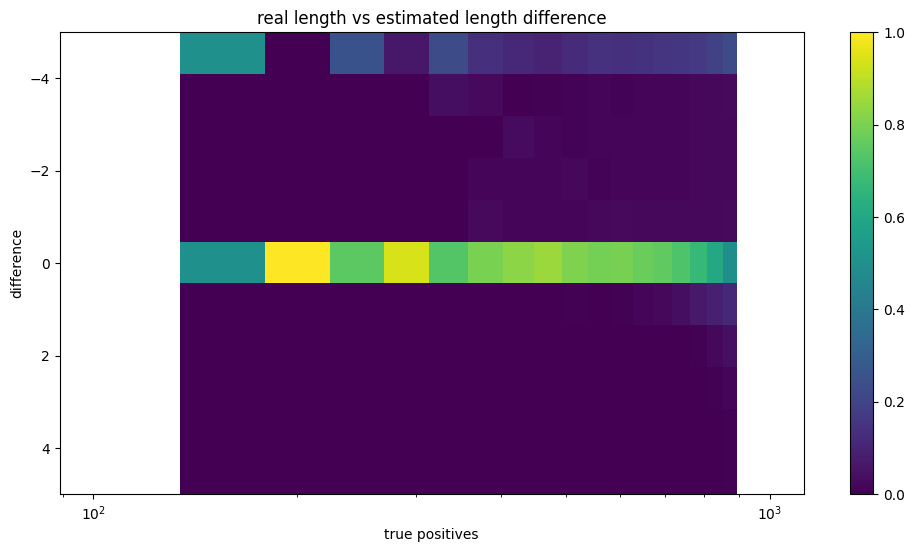

In [3]:
fig = plt.figure(figsize=(12,6))
im = plt.imshow(processed.T, extent=[0, tp[-1], 5, -5], interpolation ='none', aspect='auto')
fig.colorbar(im)
plt.title(f'real length vs estimated length difference')
plt.xlabel('true positives')
plt.xscale('log')
plt.ylabel('difference')
plt.show()
#plt.savefig(save)
plt.close('all')

In [2]:
nodes = np.array([10,12,16,20,26,33,42,54,69,88,112,143,183,233,297,379,483,615,784,1000])
tp = [0.0, 0.0, 0.0, 0.2, 0.1, 0.9, 1.6, 2.6, 7.5, 10.9, 24.5, 43.2, 70.9, 118.5, 184.2, 266.0, 372.3, 509.2, 683.4, 897.0]

data = np.array([np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0.1, 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.2, 0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.2, 0. , 0. , 0. , 0. , 1.4, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.6, 0.1, 0. , 0. , 0. , 1.9, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.9, 0.1, 0. , 0. , 0.2, 6.3, 0. , 0. , 0. , 0. , 0. ]),
 np.array([0.9, 0. , 0.3, 0.2, 0.3, 9.2, 0. , 0. , 0. , 0. , 0. ]),
 np.array([ 2.4,  0. ,  0.5,  0.5,  0.5, 20.6,  0. ,  0. ,  0. ,  0. ,  0. ]),
 np.array([ 5.5,  0.4,  0.8,  0.8,  1.1, 34.4,  0.2,  0. ,  0. ,  0. ,  0. ]),
 np.array([10.9,  1.1,  1.4,  0.5,  1.7, 54.9,  0.4,  0. ,  0. ,  0. ,  0. ]),
 np.array([18. ,  1.3,  1.6,  0.8,  2.8, 92.6,  1.4,  0. ,  0. ,  0. ,  0. ]),
 np.array([2.850e+01, 2.700e+00, 3.300e+00, 2.600e+00, 4.400e+00, 1.389e+02, 3.700e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-01]),
 np.array([4.350e+01, 3.700e+00, 4.300e+00, 4.200e+00, 6.100e+00, 1.942e+02, 9.000e+00, 7.000e-01, 1.000e-01, 1.000e-01, 1.000e-01]),
 np.array([6.360e+01, 7.100e+00, 6.700e+00, 8.100e+00, 9.000e+00, 2.557e+02, 1.880e+01, 2.800e+00, 3.000e-01, 0.000e+00, 2.000e-01]),
 np.array([102.3,  10.5,   9.7,  10.1,  11. , 312.9,  42.8,   6.3,   2.4, 0.5,   0.7]),
 np.array([153.6,  14.2,  15.7,  15.2,  16.3, 367. ,  72.1,  18.5,   5.7, 3. ,   2.1]),
 np.array([240.6,  19.6,  20.3,  20.4,  27.1, 372.8, 112.2,  47.3,  18.1, 8.7,   9.9])])

processed = []
for i, v in enumerate(data):
    processed.append(v/tp[i])
processed = np.array(processed)

C:\Users\diego\AppData\Local\Temp\ipykernel_21044\533626680.py:27: RuntimeWarning: invalid value encountered in divide
  processed.append(v/tp[i])


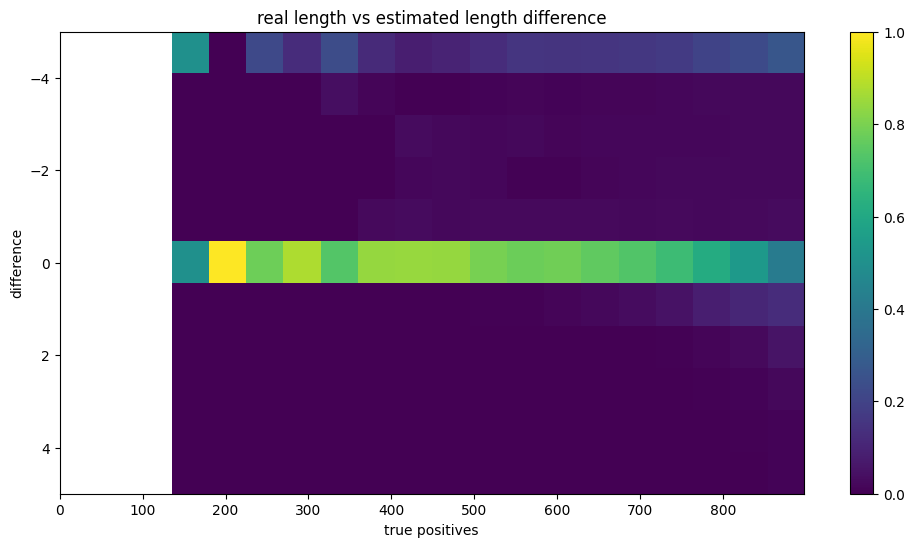

In [3]:
fig = plt.figure(figsize=(12,6))
im = plt.imshow(processed.T, extent=[0, tp[-1], 5, -5], interpolation ='none', aspect='auto')
fig.colorbar(im)
plt.title(f'real length vs estimated length difference')
plt.xlabel('true positives')
plt.ylabel('difference')
plt.show()
#plt.savefig(save)
plt.close('all')